In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=88)

latent_features = [2, 8]
learning_rates = [0.01, 0.1]
reg_params = [0.01, 0.1]
hidden_units = [32, 128]
epochs = 3

for train_index, test_index in kf.split(X_train_reduced):
    X_train_kf, X_test_kf = X_train_reduced[train_index], X[test_index]
    y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]

    model = build_autoencoder(2, 0.01, 0.01, 32)
    model.fit(X_train_kf, X_train_kf, epochs=3)

Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0418 
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5810
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4260
Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - loss: 1.0535
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.6035
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4415
Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.05518
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5927  
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.4401
Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.06210
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.582215
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4285   
Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - loss: 1.0677
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.6203
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4762


# Assignment5 - Question 1  (Alejandro Akifarry - 301-195-788)
---

In [ ]:
# newer numpy versions than this gave me errors
!pip install numpy==1.26.0

## Imports

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasRegressor

---

## 1. Use the training set, validation set, and test set from Assignment 3 (Hierarchical Clustering) for this Assignment.

In [11]:
olivetti_faces = fetch_olivetti_faces()
X = olivetti_faces.data
y = olivetti_faces.target
images = olivetti_faces.images # 64x64 version of .data
print(X.shape)
print(y.shape)

(400, 4096)
(400,)


In [12]:
# First split into train + validation (90%) and test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)

# Now split the train + validation set (90%) into train (80%) and validation (10%)
# 10/90 = 0.1111
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42, stratify=y_train_val)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(320, 4096)
(40, 4096)
(40, 4096)


---

## 2. Use PCA preserving 99% of the variance to reduce the dataset’s dimensionality as in Assignment 4 (Gaussian Mixture Models) and use it to train the autoencoder

In [13]:
pca = PCA(n_components=0.99)

X_train_reduced = pca.fit_transform(X_train)

print(X_train_reduced.shape)
print(y_train.shape)

(320, 222)
(320,)


In [14]:
X_val_reduced = pca.transform(X_val)
X_test_reduced = pca.transform(X_test)

print(X_val_reduced.shape)
print(X_test_reduced.shape)

(40, 222)
(40, 222)


---

## 3. Define an autoencoder with the given architecture.

In [32]:
# we'll use 222 for input shape because of PCA
def build_autoencoder(latent_features=2, 
                      learning_rate=0.01, 
                      regularizer_param=0.01, 
                      hidden_units=32):
  model = Sequential()

  input_shape = 222 # based on PCA on previous step

  model.add(Input(shape=(input_shape,)))

  # Top layer
  model.add(Dense(hidden_units, activation='relu', 
                  kernel_regularizer=regularizers.l2(regularizer_param)))

  # Central
  model.add(Dense(latent_features, activation='relu',
                  kernel_regularizer=regularizers.l2(regularizer_param)))

  # Decoder
  model.add(Dense(hidden_units, activation='relu',
                  kernel_regularizer=regularizers.l2(regularizer_param)))

  # Output
  model.add(Dense(units=input_shape, activation='sigmoid'))

  # Compile
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='mean_squared_error')

  return model

### a. Use k-fold cross validation to fine tune the model’s learning rate and hyperparameter of the regularizer.  Due to the long training requirements, for the number of hidden units, try two or three different values for each hidden layer.

In [33]:
model = KerasRegressor(model=build_autoencoder, epochs=30, verbose=0)

param_grid = {
    'model__latent_features': [10, 25, 50],
    'model__learning_rate': [0.01, 0.1],
    'model__regularizer_param': [0.01, 0.1],
    'model__hidden_units': [64, 128],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=3, error_score='raise')

grid_result = grid.fit(X_train_reduced, X_train_reduced)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END model__hidden_units=64, model__latent_features=10, model__learning_rate=0.01, model__regularizer_param=0.01;, score=-0.016 total time=   1.2s
[CV 2/5] END model__hidden_units=64, model__latent_features=10, model__learning_rate=0.01, model__regularizer_param=0.01;, score=-0.016 total time=   1.2s
[CV 3/5] END model__hidden_units=64, model__latent_features=10, model__learning_rate=0.01, model__regularizer_param=0.01;, score=-0.015 total time=   1.2s
[CV 4/5] END model__hidden_units=64, model__latent_features=10, model__learning_rate=0.01, model__regularizer_param=0.01;, score=-0.014 total time=   1.2s
[CV 5/5] END model__hidden_units=64, model__latent_features=10, model__learning_rate=0.01, model__regularizer_param=0.01;, score=-0.016 total time=   1.2s
[CV 1/5] END model__hidden_units=64, model__latent_features=10, model__learning_rate=0.01, model__regularizer_param=0.1;, score=-0.016 total time=   1.2s
[CV 2/5] 

In [34]:
print(f"Best Score: {grid_result.best_score_:.4f}")
print(f"Best Hyperparameters: {grid_result.best_params_}\n")

Best Score: -0.0128
Best Hyperparameters: {'model__hidden_units': 64, 'model__latent_features': 25, 'model__learning_rate': 0.1, 'model__regularizer_param': 0.01}



In [35]:
best_model = grid_result.best_estimator_

X_test_reduced = pca.transform(X_test)

reconstructed_images = best_model.predict(X_test_reduced)

reconstructed_images_full = pca.inverse_transform(reconstructed_images)

In [36]:
reconstructed_images_full.shape

(40, 4096)

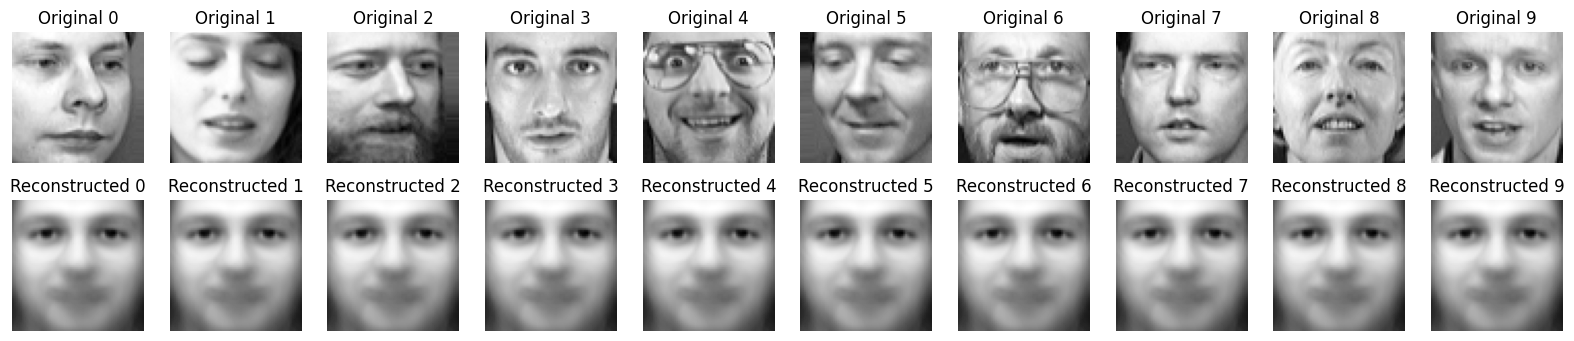

In [47]:
# Choose how many images to display
n = 10  # Number of images to display

# Reshape the images if needed, for example, if the data is flattened
image_shape = (64, 64)  # For Olivetti faces dataset, the image size is 64x64

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(image_shape), cmap='gray')
    plt.title(f"Original {i}")
    plt.axis('off')

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images_full[i].reshape(image_shape), cmap='gray')
    plt.title(f"Reconstructed {i}")
    plt.axis('off')

plt.show()

In [48]:
reconstructed_images_full[0]

array([0.4053724 , 0.438353  , 0.47750598, ..., 0.32019565, 0.31288695,
       0.30921966], dtype=float32)

In [49]:
reconstructed_images_full[1]

array([0.40537232, 0.4383529 , 0.47750586, ..., 0.32019573, 0.312887  ,
       0.30921972], dtype=float32)

In [43]:
model = build_autoencoder(
    latent_features=100,
    learning_rate=0.1,
    regularizer_param=0.00001,
    hidden_units=200)

model.fit(X_train_reduced, X_train_reduced, 
          validation_data=(X_val_reduced, X_val_reduced),
          epochs=10)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4510 - val_loss: 0.3726
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3867 - val_loss: 0.3561
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3631 - val_loss: 0.3435
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3596 - val_loss: 0.3370
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3575 - val_loss: 0.3340
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3539 - val_loss: 0.3326
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3508 - val_loss: 0.3319
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3390 - val_loss: 0.3316
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3475 - val_loss: 0.3314
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3376 - val_loss: 0.3313


In [44]:
X_test_reduced = pca.transform(X_test)

reconstructed_images = model.predict(X_test_reduced)

reconstructed_images_full = pca.inverse_transform(reconstructed_images)

reconstructed_images_full.shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


(40, 4096)

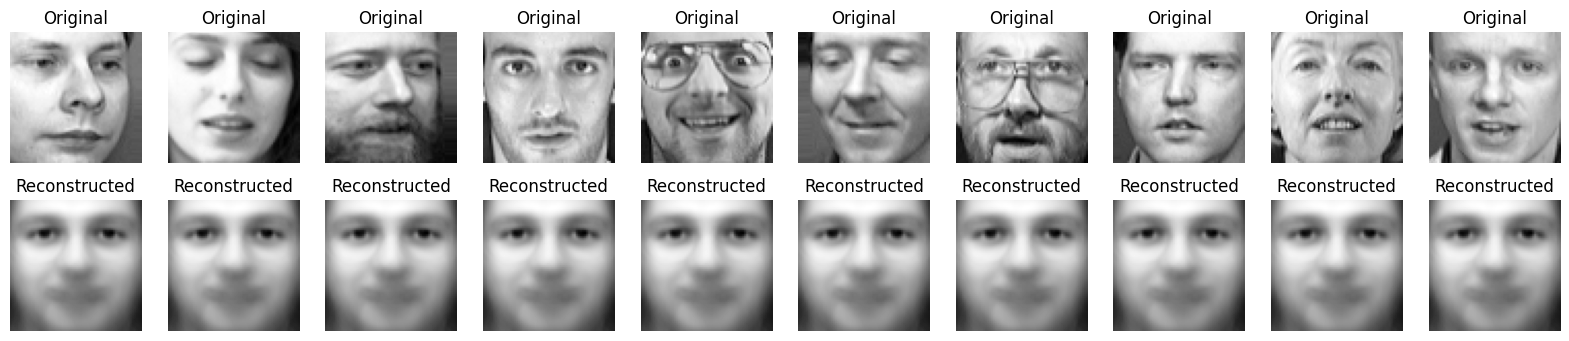

In [45]:
# Choose how many images to display
n = 10  # Number of images to display

# Reshape the images if needed, for example, if the data is flattened
image_shape = (64, 64)  # For Olivetti faces dataset, the image size is 64x64

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(image_shape), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images_full[i].reshape(image_shape), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()